Clases encontradas: ['Begonias', 'Cucarda', 'Pelargonia', 'Penacho', 'Primavera']


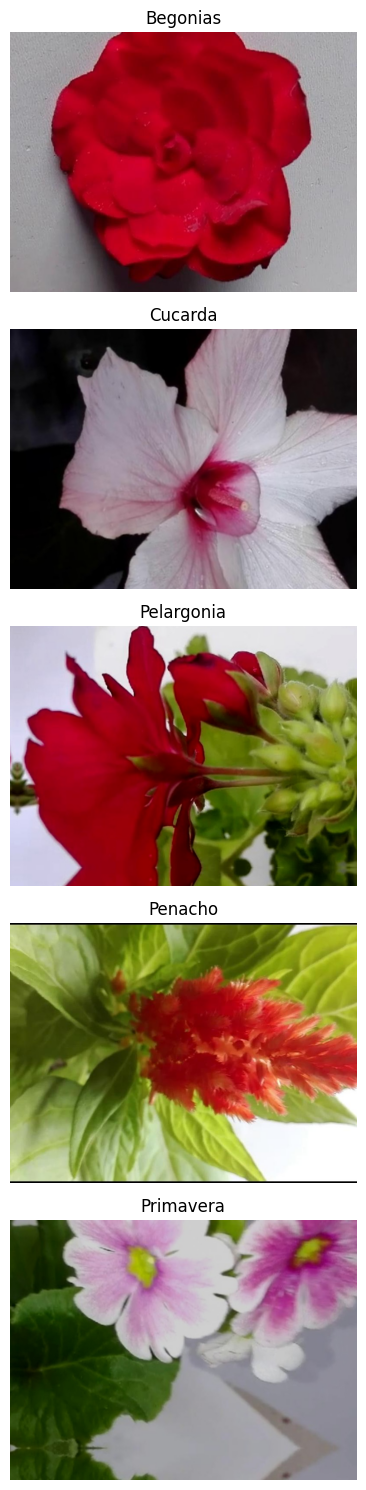

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Ruta del dataset
dataset_path = '/kaggle/input/flores-anotation/flores_anotation'

# Filtra solo carpetas (clases)
classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
print("Clases encontradas:", classes)

# Mostrar solo 1 imagen por clase
num_images = 1
fig, axs = plt.subplots(len(classes), num_images, figsize=(5, len(classes) * 3))

# Si axs es 1D, convertirlo en una lista
if len(classes) == 1:
    axs = [axs]

for i, flower_class in enumerate(classes):
    class_path = os.path.join(dataset_path, flower_class)
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if images:
        img_path = os.path.join(class_path, images[0])  # Solo la primera imagen
        img = Image.open(img_path)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(flower_class, fontsize=12)

plt.tight_layout()
plt.show()


In [3]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
import random
import json
import os
from PIL import Image
import albumentations as A
from torch import nn


In [4]:
# Configuración del dispositivo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")

# Cargamos las anotaciones
with open('/kaggle/input/flores-anotation/flores_anotation/flores_anotation.json','r') as f:
    annotations = json.load(f)

# Definimos las clases
classes = ["background", "Begonias", "Cucarda", "Pelargonia", "Penacho", "Primavera"]


Usando dispositivo: cuda


In [5]:
# Creamos un diccionario para mapear category_id a índices de clase (con 0 como background)
category_to_class = {0: 1, 1: 2, 2: 3, 3: 4, 4: 5}  # Añadimos 1 porque 0 es background

# Creamos un diccionario para mapear image_id a file_name
image_id_to_file = {}
for image in annotations['images']:
    image_id_to_file[image['id']] = image['file_name']

# Creamos un diccionario para mapear image_id a anotaciones
image_id_to_annotations = {}
for ann in annotations['annotations']:
    image_id = ann['image_id']
    if image_id not in image_id_to_annotations:
        image_id_to_annotations[image_id] = []
    image_id_to_annotations[image_id].append(ann)

In [6]:
class PlantDataset:
    def __init__(self, root_dir, annotations_dict, image_id_to_file, transforms=None):
        self.root_dir = root_dir
        self.annotations_dict = annotations_dict
        self.image_id_to_file = image_id_to_file
        self.image_ids = list(image_id_to_file.keys())
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.root_dir, self.image_id_to_file[img_id].replace('\\', '/'))

        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # Obtener anotaciones para esta imagen
        anns = self.annotations_dict.get(img_id, [])

        # Preparar bounding boxes y labels
        bboxes = []
        labels = []

        for ann in anns:
            bbox = ann['bbox']  # [x, y, width, height] en formato COCO
            # Convertimos de formato [x, y, width, height] a [xmin, ymin, xmax, ymax]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            bboxes.append(bbox)

            # Usar category_id + 1 porque 0 es background
            labels.append(category_to_class[ann['category_id']])

        # Si no hay anotaciones, creamos arrays vacíos
        if not bboxes:
            bboxes = np.zeros((0, 4))
            labels = np.zeros(0)
        else:
            bboxes = np.array(bboxes)
            labels = np.array(labels)

        # Aplicar transformaciones si existen
        if self.transforms:
            augmented = self.transforms(image=img_np, bboxes=bboxes, labels=labels)
            img_np = augmented['image']
            # Check if 'bboxes' is not empty using len()
            bboxes = np.array(augmented['bboxes']) if len(augmented['bboxes']) > 0 else np.zeros((0, 4))
            labels = np.array(augmented['labels']) if augmented['labels'] else np.zeros(0)

        return img_np, (labels, bboxes)

def get_sample(dataset, ix):
    return dataset[ix]

def plot_anns(img, anns, ax=None, bg=0):
    # anns es una tupla con (labels, bbs)
    # bbs es un array de bounding boxes en formato [x_min, y_min, x_max, y_max]
    # labels es un array que contiene la etiqueta
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    labels, bbs = anns

    for lab, bb in zip(labels, bbs):
        if bg == 0 or lab != bg:  # Ignoramos el background (que ahora es 0)
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            text = ax.text(x, y - 10, classes[int(lab)], {'color': 'red'})
            text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
            ax.add_patch(rect)

def norm(bb, shape):
    # normalizar bb
    # shape = (height, width)
    # bb = [x_min, y_min, x_max, y_max]
    h, w = shape
    return np.array([bb[0]/w, bb[1]/h, bb[2]/w, bb[3]/h])

def unnorm(bb, shape):
    # desnormalizar bb
    # shape = (height, width)
    # bb = [x_min, y_min, x_max, y_max]
    h, w = shape
    return np.array([bb[0]*w, bb[1]*h, bb[2]*w, bb[3]*h])

def xyxy2xywh(bb):
    if isinstance(bb, torch.Tensor):
        return torch.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)
    else:
        return np.stack([bb[:,0], bb[:,1], bb[:,2]-bb[:,0], bb[:,3]-bb[:,1]], axis=1)

def xywh2xyxy(bb):
    if isinstance(bb, torch.Tensor):
        return torch.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)
    else:
        return np.stack([bb[:,0], bb[:,1], bb[:,0]+bb[:,2], bb[:,1]+bb[:,3]], axis=1)

def generate_anchors(scales, centers, sizes):
    k, anchors, grid_size = [], [], []
    for s in scales:
        cnt = 0
        for (x, y) in centers:
            for (w, h) in sizes:
                for i in range(s):
                    for j in range(s):
                        # xyxy
                        anchors.append(np.array([x+i-w/2, y+j-h/2, x+i+w/2, y+j+h/2])/s)
                        grid_size.append(np.array([1./s,1./s]))
                cnt = cnt + 1
        k.append(cnt)
    return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()

def plot_anchors(img, anns, anchors, ax=None, overlap=False):
    # anns es una tupla con (labels, bbs)
    # bbs es un array de bounding boxes en formato [x_min, y_min, x_max, y_max]
    # labels es un array que contiene la etiqueta
    if not ax:
        fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(img)
    labels, bbs = anns

    anchors = xyxy2xywh(anchors)
    _anchors = np.array([unnorm(a, img.shape[:2]) for a in anchors])
    for a in _anchors:
        x, y, w, h = a
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='yellow', linewidth=2)
        ax.add_patch(rect)

    for lab, bb in zip(labels, bbs):
        x, y, xm, ym = bb
        w, h = xm - x, ym - y
        rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
        text = ax.text(x, y - 10, classes[int(lab)], {'color': 'red'})
        text.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])
        ax.add_patch(rect)

def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

def flatten_conv(x, k):
    # Use contiguous() to ensure the tensor is contiguous in memory
    return x.contiguous().view(x.size(0), x.size(1)//k, -1).transpose(1,2)

class out_conv(torch.nn.Module):
    def __init__(self, c_in, k, n_classes):
        super().__init__()
        self.k = k
        self.oconv1 = torch.nn.Conv2d(c_in, k*4, 3, padding=1)
        self.oconv2 = torch.nn.Conv2d(c_in, k*n_classes, 3, padding=1)
    def forward(self, x):
        return [
            flatten_conv(self.oconv1(x), self.k),
            flatten_conv(self.oconv2(x), self.k)
        ]

In [7]:
class SSD(torch.nn.Module):
    def __init__(self, n_channels=3, n_classes=6, k=[1, 1, 1]):  # n_classes = 6 (bg + 5 plantas)
        super().__init__()
        # backbone
        self.conv1 = block(n_channels, 8)
        self.conv2 = block(8, 16)
        self.conv3 = block(16, 32)
        self.conv4 = block(32, 64)
        self.conv5 = block(64, 64)
        self.conv6 = block(64, 64)
        # head
        self.k = k
        self.out4 = out_conv(64, self.k[0], n_classes)
        self.out5 = out_conv(64, self.k[1], n_classes)
        self.out6 = out_conv(64, self.k[2], n_classes)

    def forward(self, x):
        # backbone
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)     # para inputs de 100x100
        x4 = self.conv4(x)    # 6x6
        x5 = self.conv5(x4)   # 3x3
        x6 = self.conv6(x5)   # 1x1

        # head
        o1l, o1c = self.out4(x4)
        o2l, o2c = self.out5(x5)
        o3l, o3c = self.out6(x6)
        return torch.cat([o1l,o2l,o3l],dim=1), torch.cat([o1c,o2c,o3c],dim=1)

def actn_to_bb(actn, anchors, grid_size):
    actn_bbs = torch.tanh(actn)
    actn_p1 = anchors[:,:2] + actn_bbs[:,:2]*grid_size*0.5
    actn_p2 = anchors[:,2:] + actn_bbs[:,2:]*grid_size*0.5
    return torch.cat([actn_p1, actn_p2], dim=1)

def map_to_ground_truth(overlaps):
    prior_overlap, prior_idx = overlaps.max(1)
    gt_overlap, gt_idx = overlaps.max(0)
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap, gt_idx

class SSDLoss(torch.nn.Module):
    def __init__(self, anchors, grid_size, threshold=0.4):
        super().__init__()
        self.loc_loss = torch.nn.L1Loss()
        self.class_loss = torch.nn.CrossEntropyLoss()
        self.anchors = anchors.to(device)
        self.grid_size = grid_size.to(device)
        self.threshold = threshold

    def forward(self, preds, target):
        pred_bbs, pred_cs = preds
        tar_bbs, c_t = target  # B x O x 4, B x O
        # cada imagen del batch puede tener un número diferente de detecciones
        loc_loss, clas_loss = 0, 0
        for pred_bb, pred_c, tar_bb, tar_c in zip(pred_bbs, pred_cs, tar_bbs, c_t):
            labels = torch.zeros(len(self.anchors)).long().to(device)  # por defecto todas las etiquetas son `background`
            if tar_bb.shape[0] != 0:  # es posible que haya imágenes sin detecciones
                # calculamos el IoU de las detecciones con las cajas
                overlaps = torchvision.ops.box_iou(tar_bb, self.anchors)
                # nos quedamos con aquellas que coincidan
                gt_overlap, gt_idx = map_to_ground_truth(overlaps)
                pos = gt_overlap > self.threshold
                # optimizamos para aquellas cajas que superen el filtro
                pos_idx = torch.nonzero(pos)[:,0]
                if len(pos_idx) > 0:  # verificamos que haya coincidencias positivas
                    tar_idx = gt_idx[pos_idx]
                    pred_bb = actn_to_bb(pred_bb, self.anchors, self.grid_size)
                    _anchors = pred_bb[pos_idx]
                    tar_bb = tar_bb[tar_idx]
                    loc_loss += self.loc_loss(_anchors, tar_bb)
                    labels[pos_idx] = tar_c[tar_idx]
            clas_loss += self.class_loss(pred_c, labels)
        return clas_loss + loc_loss


In [8]:
def fit(model, train_loader, epochs=10, lr=3e-4):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = SSDLoss(anchors, grid_size)

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = []

        for i, (imgs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            # Convertir numpy arrays a tensores
            imgs_tensor = torch.FloatTensor(imgs / 255.).permute(0, 3, 1, 2).to(device)

            # Preparar targets
            labels_batch, bbs_batch = targets
            bb_tensors, label_tensors = [], []

            for j, (labels, bbs) in enumerate(zip(labels_batch, bbs_batch)):
                # Normalizar bounding boxes
                if len(bbs) > 0:  # Si hay bounding boxes
                    bb_norm = [norm(bb, imgs[j].shape[:2]) for bb in bbs]
                    bb_tensor = torch.FloatTensor(bb_norm).to(device)
                    label_tensor = torch.tensor(labels).long().to(device)
                else:  # Si no hay bounding boxes
                    bb_tensor = torch.zeros((0, 4)).to(device)
                    label_tensor = torch.zeros(0).long().to(device)

                bb_tensors.append(bb_tensor)
                label_tensors.append(label_tensor)

            # Forward y loss
            outputs = model(imgs_tensor)
            loss = criterion(outputs, (bb_tensors, label_tensors))

            # Backward
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            if (i+1) % 10 == 0:
                print(f"Epoch {epoch}/{epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.5f}")

        print(f"Epoch {epoch}/{epochs}, Average Loss: {np.mean(train_loss):.5f}")

    return model

def predict(model, X, anchors, grid_size, conf_threshold=0.5, nms_threshold=0.5):
    model.eval()
    with torch.no_grad():
        X = X.to(device)
        bbs, labels = model(X)

        # Procesar cada imagen en el batch
        results = []
        for i in range(X.shape[0]):
            bbs_i = actn_to_bb(bbs[i].cpu(), anchors, grid_size)
            scores_i, labels_i = torch.max(torch.softmax(labels[i].cpu(), dim=1), dim=1)

            # Filtrar fondo y baja confianza
            mask = (labels_i > 0) & (scores_i > conf_threshold)
            bbs_i, labels_i, scores_i = bbs_i[mask], labels_i[mask], scores_i[mask]

            if len(bbs_i) > 0:
                # NMS
                nms_ixs = torchvision.ops.nms(bbs_i, scores_i, iou_threshold=nms_threshold)
                bbs_i, labels_i = bbs_i[nms_ixs], labels_i[nms_ixs]

            results.append((bbs_i, labels_i))

    return results


In [9]:
# Configuración de transformaciones
train_transform = A.Compose([
    A.Resize(100, 100),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transform = A.Compose([
    A.Resize(100, 100),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# Crear dataset
train_dataset = PlantDataset(
    root_dir='/kaggle/input/flores-anotation/flores_anotation',
    annotations_dict=image_id_to_annotations,
    image_id_to_file=image_id_to_file,
    transforms=train_transform
)

# Crear dataloaders
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = []
    labels_list = []
    bboxes_list = []

    for img, (labels, bboxes) in batch:
        images.append(img)
        labels_list.append(labels)
        bboxes_list.append(bboxes)

    return np.array(images), (labels_list, bboxes_list)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


In [10]:

# Definir anchors
scales = [6, 3, 1]
centers = [(0.5, 0.5)]
size_scales = [1]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)

/tmp/ipykernel_35/3977212212.py:113: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return k, torch.tensor(anchors).float(), torch.tensor(grid_size).float()


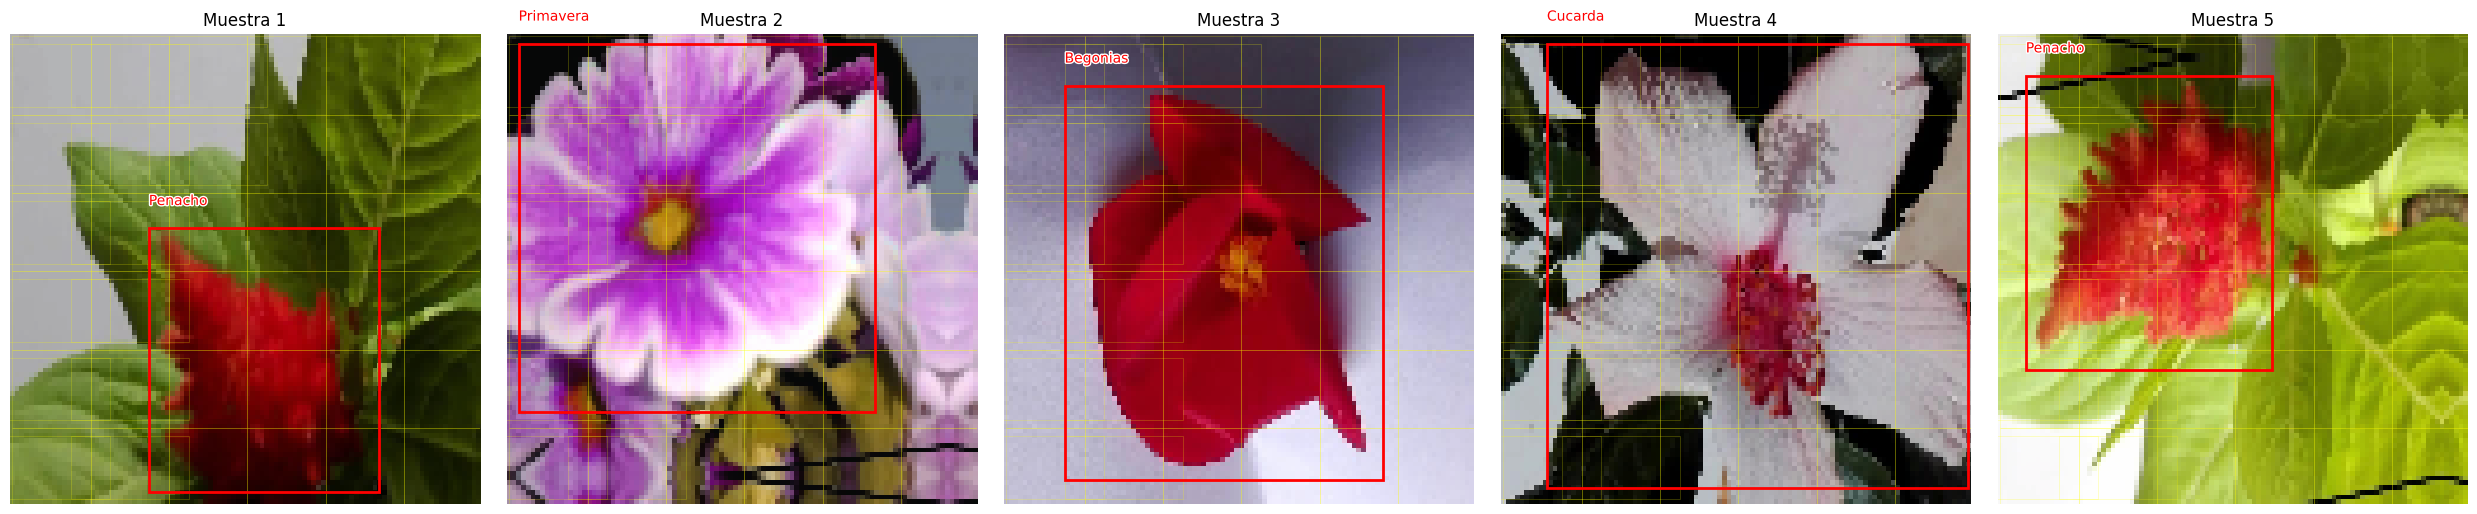

In [11]:
def visualize_trainloader_samples(train_loader, anchors, num_samples=5):
    # Obtener un batch de datos
    batch = next(iter(train_loader))
    images, (all_labels, all_bboxes) = batch

    # Configurar la figura
    fig, axes = plt.subplots(1, num_samples, figsize=(25, 5))

    # Desnormalización para visualización
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(num_samples):
        if i >= len(images):
            break

        # Procesar imagen
        img = images[i].copy()
        img = (img * std + mean).clip(0, 1)  # Desnormalizar

        # Obtener anotaciones
        labels = all_labels[i]
        bboxes = all_bboxes[i]

        # Convertir anchors a coordenadas de imagen
        img_h, img_w = img.shape[:2]
        denorm_anchors = [unnorm(anchor, (img_h, img_w)) for anchor in anchors.cpu().numpy()]

        # Crear subplot
        ax = axes[i] if num_samples > 1 else axes
        ax.imshow(img)
        ax.set_title(f'Muestra {i+1}')
        ax.axis('off')

        # Dibujar anchors (amarillo)
        for anchor in denorm_anchors[:50]:  # Mostrar solo primeros 50 anchors para claridad
            x, y, xm, ym = anchor
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='yellow', linewidth=0.5, alpha=0.3)
            ax.add_patch(rect)

        # Dibujar cajas reales (rojo)
        for lab, bb in zip(labels, bboxes):
            x, y, xm, ym = bb
            w, h = xm - x, ym - y
            rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
            text = ax.text(x, y - 5, classes[lab], color='red', fontsize=10)
            text.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Uso:
visualize_trainloader_samples(train_loader, anchors, num_samples=5)

In [12]:


# Visualizar algunas muestras
def visualize_samples(dataset, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        img, anns = dataset[idx]
        plot_anns(img, anns, ax=axes[i])
        axes[i].set_title(f"Muestra {idx}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Visualizamos muestras con anchors
def visualize_samples_with_anchors(dataset, anchors, num_samples=4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    for i in range(num_samples):
        idx = random.randint(0, len(dataset)-1)
        img, anns = dataset[idx]
        plot_anchors(img, anns, anchors, ax=axes[i])
        axes[i].set_title(f"Muestra {idx} con anchors")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

# Creamos el modelo SSD
model = SSD(n_classes=len(classes), k=k)  # 6 clases (background + 5 plantas)

# Para entrenar el modelo:
model = fit(model, train_loader, epochs=3000)

torch.save(model.state_dict(), '/kaggle/working/ssd_modelflor.pth')


Epoch 1/3000, Batch 10/32, Loss: 29.76330
Epoch 1/3000, Batch 20/32, Loss: 25.87532
Epoch 1/3000, Batch 30/32, Loss: 15.94169
Epoch 1/3000, Average Loss: 25.29762
Epoch 2/3000, Batch 10/32, Loss: 5.64102
Epoch 2/3000, Batch 20/32, Loss: 2.66915
Epoch 2/3000, Batch 30/32, Loss: 2.81529
Epoch 2/3000, Average Loss: 4.86701
Epoch 3/3000, Batch 10/32, Loss: 2.02413
Epoch 3/3000, Batch 20/32, Loss: 2.45493
Epoch 3/3000, Batch 30/32, Loss: 2.24946
Epoch 3/3000, Average Loss: 2.20248
Epoch 4/3000, Batch 10/32, Loss: 2.17516
Epoch 4/3000, Batch 20/32, Loss: 2.07635
Epoch 4/3000, Batch 30/32, Loss: 2.13298
Epoch 4/3000, Average Loss: 2.09506
Epoch 5/3000, Batch 10/32, Loss: 2.01424
Epoch 5/3000, Batch 20/32, Loss: 2.02437
Epoch 5/3000, Batch 30/32, Loss: 1.97502
Epoch 5/3000, Average Loss: 2.05369
Epoch 6/3000, Batch 10/32, Loss: 2.10732
Epoch 6/3000, Batch 20/32, Loss: 2.13367
Epoch 6/3000, Batch 30/32, Loss: 2.17031
Epoch 6/3000, Average Loss: 2.00945
Epoch 7/3000, Batch 10/32, Loss: 2.25456
E

In [15]:
def debug_predict(
    model, image_path, anchors, grid_size, test_transform=None,
    device='cuda', conf_th=0.5, nms_th=0.5, classes=None
):
    """
    Ejecuta el flujo completo de predict paso a paso:
    1) Raw outputs del modelo: locs y confs
    2) Decodificación contra anchors
    3) Softmax + argmax para scores y labels
    4) Filtrado por fondo y umbral de confianza
    5) NMS
    6) Dibujo en imagen
    """
    # Default classes if not provided
    if classes is None:
        classes = ["background", "Begonias", "Cucarda", "Pelargonia", "Penacho", "Primavera"]

    model.eval()
    # --- 1) Carga y preproceso
    img = Image.open(image_path).convert("RGB")
    img_np = np.array(img)

    # Apply test transform if provided
    if test_transform:
        transformed = test_transform(image=img_np, bboxes=[], labels=[])
        img_transformed = transformed['image']
        # For visualization, keep original
        img_for_display = img_np.copy()
    else:
        # If no transform, manually resize and normalize
        img_transformed = np.array(img.resize((100, 100)))
        img_transformed = img_transformed / 255.0  # Simple normalization
        img_for_display = img_np.copy()

    img_tensor = torch.FloatTensor(img_transformed).permute(2,0,1).unsqueeze(0).to(device)

    # --- 2) Raw model output
    with torch.no_grad():
        pred_locs, pred_confs = model(img_tensor)
    print("pred_locs.shape:", pred_locs.shape)   # (1, A, 4)
    print("pred_confs.shape:", pred_confs.shape) # (1, A, C)
    print("anchors.shape:", anchors.shape)       # (A, 4)
    print("grid_size.shape:", grid_size.shape)   # (A, 2)

    # Verificar si necesitamos regenerar los anchors con el número correcto
    if pred_locs.shape[1] != anchors.shape[0]:
        print(f"ERROR: Mismatch entre predicciones ({pred_locs.shape[1]}) y anchors ({anchors.shape[0]})")
        print("Regenerando anchors para que coincidan...")

        # Determinar aspect_ratios y recalcular
        num_sizes = pred_locs.shape[1] // sum([s*s for s in [6, 3, 1]])
        print(f"Estimando {num_sizes} tamaños/aspect ratios por celda")

        scales = [6, 3, 1]
        centers = [(0.5, 0.5)]
        size_scales = [1]

        # Ajustar aspect_ratios según sea necesario
        if num_sizes == 9:
            aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4),
                            (0.8, 1.5), (0.4, 1.8),
                            (2.0, 0.6), (0.6, 2.0),
                            (1.2, 1.2), (0.7, 0.7)]
        elif num_sizes == 6:
            aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4),
                            (0.8, 1.5), (0.4, 1.8), (1.2, 1.2)]
        elif num_sizes == 3:
            aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
        else:
            # Crear suficientes aspect_ratios
            aspect_ratios = [(1., 1.)]
            for i in range(1, int(num_sizes/2) + 1):
                r = 1.0 + (i * 0.5)
                aspect_ratios.append((r, 1/r))
                aspect_ratios.append((1/r, r))

        # Limitar a la cantidad necesaria
        aspect_ratios = aspect_ratios[:num_sizes]

        sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
        k, anchors, grid_size = generate_anchors(scales, centers, sizes)

        # Verificar nuevamente
        print(f"Nuevos anchors generados: {len(anchors)}")
        print(f"Predicciones esperadas: {pred_locs.shape[1]}")

        # Mover a device correcto
        anchors = anchors.to(device)
        grid_size = grid_size.to(device)

    # Sacamos el batch=0 al CPU
    loc0  = pred_locs[0].cpu()   # (A,4)
    conf0 = pred_confs[0].cpu()  # (A,C)
    anchors_cpu = anchors.cpu()
    grid_size_cpu = grid_size.cpu()

    # --- 3) Decodificar offsets a cajas
    decoded_bbs = actn_to_bb(loc0, anchors_cpu, grid_size_cpu)
    print("decoded_bbs.shape:", decoded_bbs.shape)  # (A,4)

    # --- 4) Softmax + argmax
    conf_soft = torch.softmax(conf0, dim=1)   # (A,C)
    scores, labels = torch.max(conf_soft, dim=1)  # (A,), (A,)
    print("scores.shape:", scores.shape)
    print("labels.shape:", labels.shape)

    # --- 5) Filtrar fondo y baja confianza
    keep = (labels > 0) & (scores > conf_th)
    print("keep.sum():", keep.sum().item())
    bbs_f    = decoded_bbs[keep]
    labels_f = labels[keep]
    scores_f = scores[keep]
    print(" after filter → bbs_f.shape:", bbs_f.shape)

    if len(bbs_f) == 0:
        print("No se encontraron detecciones que superen el umbral de confianza")
        plt.figure(figsize=(6,6))
        plt.imshow(img_for_display)
        plt.title(f"Sin detecciones > {conf_th*100:.0f}%")
        plt.axis('off')
        plt.show()
        return None, None, None

    # --- 6) Non-max suppression
    keep_nms = torchvision.ops.nms(bbs_f, scores_f, iou_threshold=nms_th)
    print("NMS keep indices:", keep_nms)
    bbs_n    = bbs_f[keep_nms]
    labels_n = labels_f[keep_nms]
    scores_n = scores_f[keep_nms]
    print(" after NMS → bbs_n.shape:", bbs_n.shape)

    # --- 7) Dibujo
    def plot_detections(img, boxes, labels, scores, classes, score_threshold):
        plt.figure(figsize=(8,8))
        plt.imshow(img)
        for box, lab, sc in zip(boxes, labels, scores):
            x1,y1,x2,y2 = box.tolist()
            x1, y1, x2, y2 = max(0, x1), max(0, y1), min(img.shape[1], x2), min(img.shape[0], y2)
            plt.gca().add_patch(
                plt.Rectangle((x1,y1), x2-x1, y2-y1,
                              fill=False, edgecolor='red', linewidth=2)
            )
            plt.text(x1, y1-5, f"{classes[int(lab)]} {sc:.2f}",
                     color='white', backgroundcolor='red')
        plt.axis('off')
        plt.title(f"Detecciones >{conf_th*100:.0f}%")
        plt.show()

    # Desnormalizar cajas antes de dibujar
    bbs_n_unnorm = [unnorm(bb, img_for_display.shape[:2]) for bb in bbs_n]
    plot_detections(img_for_display, bbs_n_unnorm, labels_n, scores_n, classes, conf_th)

    # Imprimir resultados en texto
    print("\nDetecciones:")
    for i, (label, bbox, score) in enumerate(zip(labels_n, bbs_n_unnorm, scores_n)):
        print(f"  {i+1}. {classes[int(label)]} (conf: {score:.2f}): {[round(x) for x in bbox]}")

    return bbs_n, labels_n, scores_n

pred_locs.shape: torch.Size([1, 138, 4])
pred_confs.shape: torch.Size([1, 138, 6])
anchors.shape: torch.Size([138, 4])
grid_size.shape: torch.Size([138, 2])
decoded_bbs.shape: torch.Size([138, 4])
scores.shape: torch.Size([138])
labels.shape: torch.Size([138])
keep.sum(): 3
 after filter → bbs_f.shape: torch.Size([3, 4])
NMS keep indices: tensor([1, 2, 0])
 after NMS → bbs_n.shape: torch.Size([3, 4])


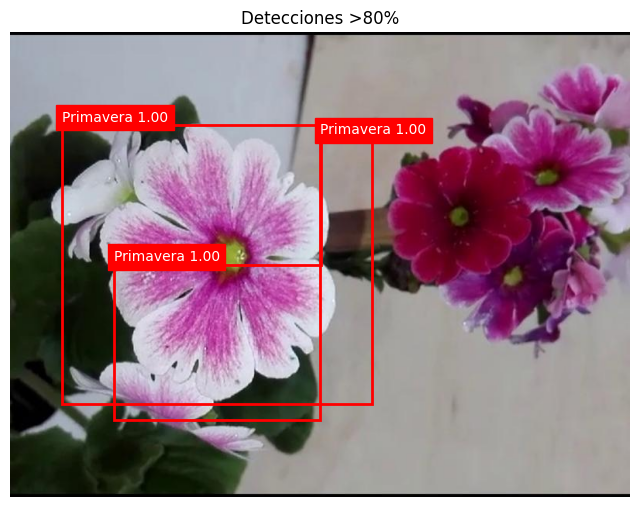


Detecciones:
  1. Primavera (conf: 1.00): [67, 120, 467, 480]
  2. Primavera (conf: 1.00): [400, 136, 400, 300]
  3. Primavera (conf: 1.00): [133, 300, 400, 500]


In [22]:
# 2. Cargamos el modelo entrenado
model_path = '/kaggle/working/ssd_modelflor.pth'  # Ajusta ruta según corresponda
# Change k to match the original training configuration
model = SSD(n_classes=len(classes), k=k)  # Use the k value defined during training
model.to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# 4. Regeneramos anchors apropiados
# The original code called a function 'regenerate_anchors' which wasn't defined.
# Assuming you meant to use 'generate_anchors', I've replaced the call below.
# Please adjust the scales, centers, sizes as per your training configuration.
scales = [6, 3, 1]
centers = [(0.5, 0.5)]
size_scales = [1]
aspect_ratios = [(1., 1.), (1.5, 0.8), (1.8, 0.4)]
sizes = [(s*a[0], s*a[1]) for s in size_scales for a in aspect_ratios]
k, anchors, grid_size = generate_anchors(scales, centers, sizes)


anchors = anchors.to(device)
grid_size = grid_size.to(device)

image_path = '/kaggle/input/flores-anotation/flores_anotation/Primavera/Flor Primavera 55.jpg'  # Ajusta según necesidad
#image_path='/kaggle/input/flores-anotation/flores_anotation/Cucarda/Flor Cucarda 55.jpg'
# Probamos con un umbral bajo para ver más detecciones
bbs, labs, scores = debug_predict(
    model,
    image_path,
    anchors,
    grid_size,
    device=device,
    conf_th=0.8,  # Umbral de confianza
    nms_th=0.5,   # Umbral de NMS
    classes=classes
)

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

pred_dir = '/content/runs/detect/train23'
pred_files = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))]

for file in pred_files[:5]:
    img_path = os.path.join(pred_dir, file)
    img = Image.open(img_path)
    plt.figure()
    plt.imshow(img)
    plt.title(file)
    plt.axis("off")
plt.show()


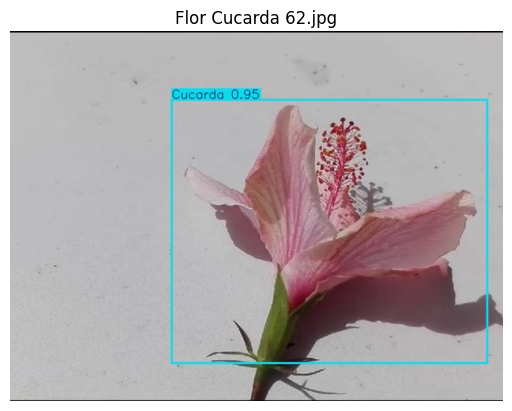
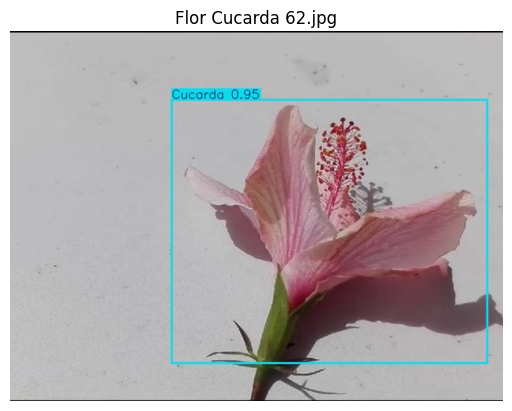
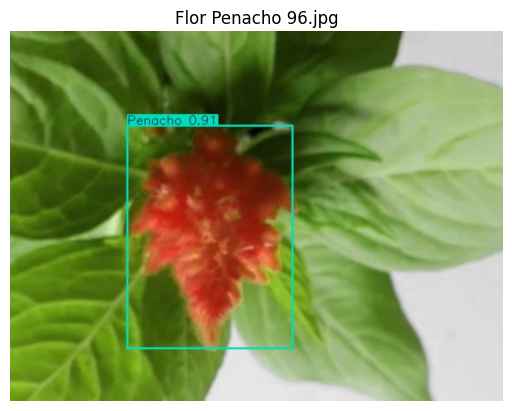
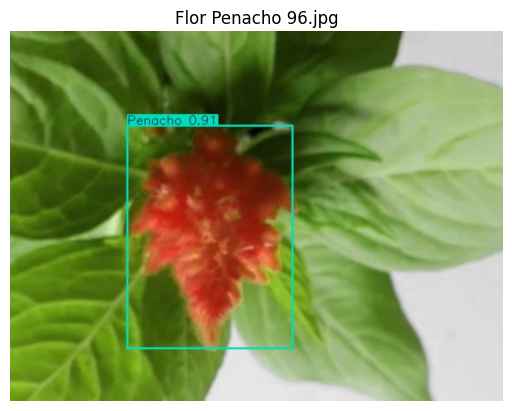
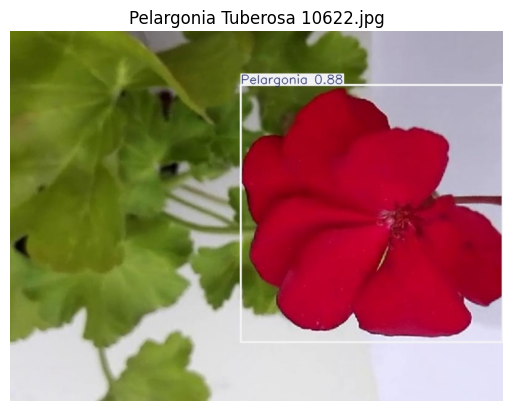
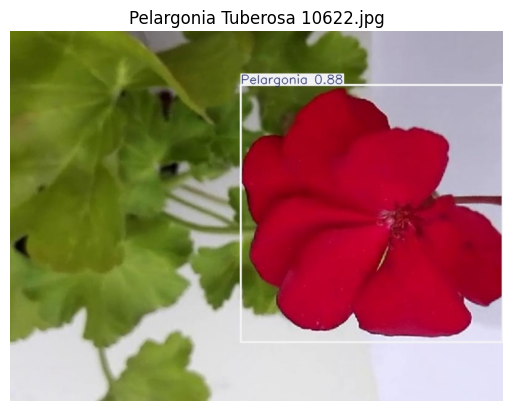
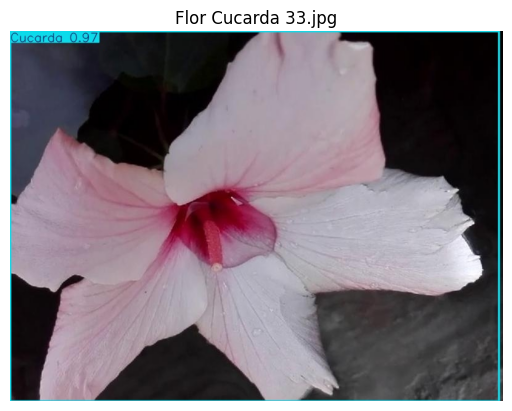
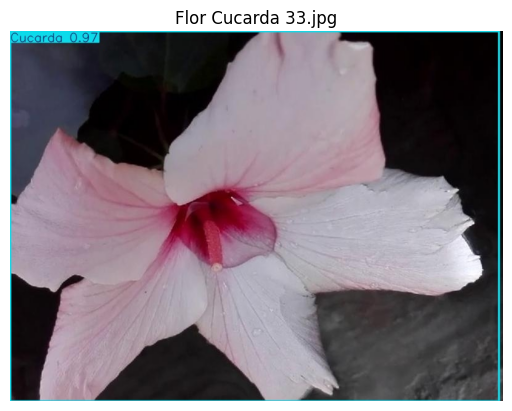
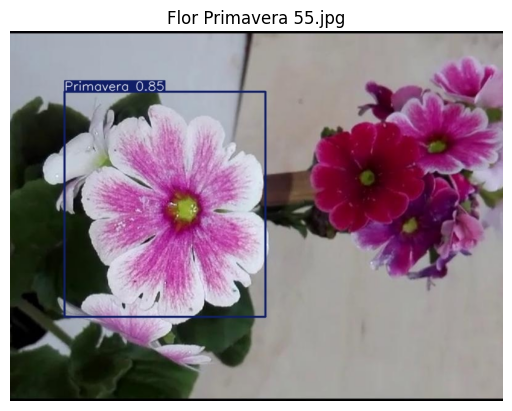
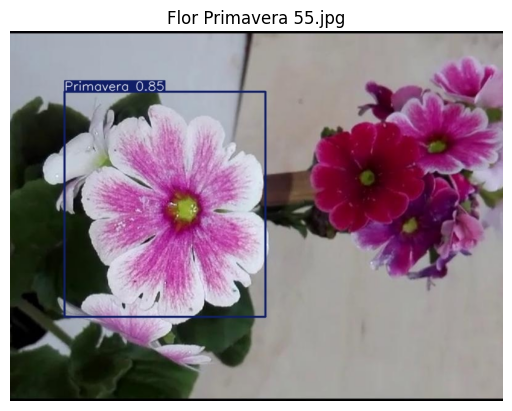